# 🎯 Thin Cloud Detection with Reinforcement Learning

**Research Goal**: Specifically improve CNN's detection of THIN/CIRRUS clouds (their main weakness)

**Approach**: Multi-Feature RL with thin cloud boost action

---

## Background

**CNN Weakness**: Thin clouds have low reflectance → low CNN probability → missed detection

**Our Solution**: RL agent learns to:
- Identify thin cloud patterns (blue/red ratio, moderate reflectance)
- Apply probability boost specifically for thin clouds
- Filter false positives on shadows using spectral indices

**Key Innovation**: `thin_cloud_boost` action [0, 0.4] that increases confidence for thin cloud pixels

## 1️⃣ Setup Environment

In [1]:
# Clone repository
!git clone https://github.com/Usernamenisiya/thesis-cloud-rl.git
%cd thesis-cloud-rl

# Verify
!pwd
!ls -la | head -15

Cloning into 'thesis-cloud-rl'...
remote: Enumerating objects: 1870, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 1870 (delta 66), reused 88 (delta 33), pack-reused 1742 (from 2)
Receiving objects: 100% (1870/1870), 655.34 MiB | 37.32 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Updating files: 100% (2649/2649), done.
/content/thesis-cloud-rl
/content/thesis-cloud-rl
total 41892
drwxr-xr-x 6 root root     4096 Jan 14 04:34 .
drwxr-xr-x 1 root root     4096 Jan 14 04:34 ..
-rw-r--r-- 1 root root     3567 Jan 14 04:34 analyze_data_distribution.py
-rw-r--r-- 1 root root     7531 Jan 14 04:34 analyze_thin_cloud_features.py
-rw-r--r-- 1 root root     5945 Jan 14 04:34 cloudsen12_loader.py
-rw-r--r-- 1 root root     1661 Jan 14 04:34 cnn_inference.py
-rw-r--r-- 1 root root  1887654 Jan 14 04:34 colab_training.ipynb
-rw-r--r-- 1 root root    33657 Jan 14 04:34 colab_training_old.ipynb
drwxr-xr-x 3 root root     40

In [2]:
# Install dependencies
!pip install -r requirements.txt
!pip install gymnasium scikit-image

import torch
import stable_baselines3
import rasterio

print("✅ Dependencies installed")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Dependencies installed
PyTorch: 2.9.0+cpu
CUDA available: False


In [3]:
# Check GPU
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

/bin/bash: line 1: nvidia-smi: command not found

✅ Using device: cpu


## 2️⃣ Load CloudSEN12 Data

In [4]:
# Mount Google Drive
from google.colab import drive
import os
from pathlib import Path

drive.mount('/content/drive')

# Verify CloudSEN12 data exists
cloudsen_path = '/content/drive/MyDrive/Colab_Data/cloudsen12_subset'

if os.path.exists(cloudsen_path):
    num_patches = len([d for d in Path(cloudsen_path).iterdir() if d.is_dir()])
    print(f"✅ CloudSEN12 data found: {num_patches} patches")
    print(f"📂 Location: {cloudsen_path}")

    # Process CloudSEN12 data
    print("\n🔧 Processing CloudSEN12 patches...")
    !python cloudsen12_loader.py
else:
    print(f"❌ CloudSEN12 data not found at: {cloudsen_path}")

Mounted at /content/drive
✅ CloudSEN12 data found: 100 patches
📂 Location: /content/drive/MyDrive/Colab_Data/cloudsen12_subset

🔧 Processing CloudSEN12 patches...

🔧 Preparing CloudSEN12 for Training
📦 Loading CloudSEN12 Data

✅ Found 100 patches to load


✅ Successfully loaded 100 patches
📊 Image shape: (512, 512, 10)
📊 Mask shape: (512, 512)
📊 Image bands: 10
📊 Cloud coverage: 16.0%

💾 Saving 100 patches to data/cloudsen12_processed
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
  Saved: patch_000
  Saved: patch_001
  Saved: patch_002
  Saved: patch_003
  Saved: patch_004
  Saved: patch_005
  Saved: patch_006
  Saved: patch_007
  Saved: patch_008
  Saved: patch_009
  Saved: patch_010
  Saved: patch_011
  Saved: patch_012
  Saved: patch_013
  Saved: patch_014
  Saved: patch_015
  Saved: patch_016
  Saved: patch_017
  Saved: patch_018
  Saved

In [5]:
# Verify processed data
import glob

processed_dir = 'data/cloudsen12_processed'
image_files = glob.glob(f'{processed_dir}/*_image.tif')
mask_files = glob.glob(f'{processed_dir}/*_mask.tif')

print(f"✅ Found {len(image_files)} image patches")
print(f"✅ Found {len(mask_files)} mask patches")
print(f"\n🎯 Ready for thin cloud detection training!")

✅ Found 100 image patches
✅ Found 100 mask patches

🎯 Ready for thin cloud detection training!


## 3️⃣ Baseline CNN Performance

In [6]:
# Evaluate baseline CNN on all patches
from cnn_inference import load_sentinel2_image, get_cloud_mask
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("🧠 Evaluating CNN Baseline")
print("="*60)

all_gt = []
all_cnn = []

for img_path, mask_path in zip(image_files, mask_files):
    image = load_sentinel2_image(img_path)
    cnn_prob = get_cloud_mask(image)

    with rasterio.open(mask_path) as src:
        ground_truth = src.read(1)

    gt_binary = (ground_truth > 0).astype(np.uint8)
    cnn_binary = (cnn_prob > 0.5).astype(np.uint8)

    all_gt.append(gt_binary.flatten())
    all_cnn.append(cnn_binary.flatten())

all_gt = np.concatenate(all_gt)
all_cnn = np.concatenate(all_cnn)

print(f"\n📊 CNN Baseline (threshold=0.5):")
print(f"  Accuracy:  {accuracy_score(all_gt, all_cnn):.4f}")
print(f"  Precision: {precision_score(all_gt, all_cnn, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(all_gt, all_cnn, zero_division=0):.4f}")
print(f"  F1-Score:  {f1_score(all_gt, all_cnn, zero_division=0):.4f}")
print(f"\n⚠️ Hypothesis: Poor performance on THIN clouds specifically")

🧠 Evaluating CNN Baseline


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



📊 CNN Baseline (threshold=0.5):
  Accuracy:  0.6744


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Precision: 0.1508


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Recall:    0.2222


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  F1-Score:  0.1796

⚠️ Hypothesis: Poor performance on THIN clouds specifically


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4️⃣ Pull Latest Code

In [7]:
# Get latest thin cloud detection code
!git pull origin master
print("✅ Repository updated with thin cloud detection features")

From https://github.com/Usernamenisiya/thesis-cloud-rl
 * branch            master     -> FETCH_HEAD
Already up to date.
✅ Repository updated with thin cloud detection features


## 🎯 Train Thin Cloud Detection Agent

**Features**:
- Optical thickness indicators (blue/red ratio, reflectance levels)
- Thin vs thick cloud classification
- Spectral indices (NDSI, NDVI)

**Actions**:
- `threshold_delta` [-0.3, +0.3]: Base threshold adjustment
- `thin_cloud_boost` [0, 0.4]: **Extra boost for thin clouds** (KEY!)
- `spectral_weight` [0, 1]: Filter false positives

**Reward**:
- **BIG BONUS** for detecting thin clouds (5x multiplier)
- Extra rewards for high thin cloud recall (>50%, >70%)
- Penalties for false positives on shadows
- Penalties for missing thick clouds

**Training Time**: 2-3 hours

In [8]:
# Train thin cloud detection agent
print("🚀 Training Thin Cloud Detection RL Agent...")
print("This will take approximately 2-3 hours")
print("="*80)

!python train_ppo_multifeature.py

Streaming output truncated to the last 5000 lines.
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 4            |
|    time_elapsed         | 120          |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0064494824 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.55        |
|    explained_variance   | 0.848        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.3         |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.00465     |
|    std                  | 0.8          |
|    value_loss           | 51.5         |
------------------------------------------
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8,192/6,250  [ 0:01:34 < 0:00:00 , 61 it/s ]
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dat

In [13]:
!git pull origin master
!python analyze_thin_cloud_features.py

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.03 KiB | 350.00 KiB/s, done.
From https://github.com/Usernamenisiya/thesis-cloud-rl
 * branch            master     -> FETCH_HEAD
   3e8d8df..8eee6de  master     -> origin/master
Updating 3e8d8df..8eee6de
Fast-forward
 analyze_thin_cloud_features.py |  4 ++--
 rl_multifeature_environment.py | 31 ++++++++++++++++---------------
 2 files changed, 18 insertions(+), 17 deletions(-)
Found 100 patches
Analyzing 20 patches...
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)

THIN CLOUD FEATURES
Blue/Red Ratio:  Mean=0.920, Std=0.119
Reflectance: 

## 📊 Results Analysis

**Key Metrics to Check**:
1. **Thin Cloud Recall**: Did we detect more thin clouds?
2. **Thin Cloud F1-Score**: Overall thin cloud performance
3. **Thick Cloud Recall**: Did we maintain performance on thick clouds?
4. **Overall Improvement**: Total F1-score gain
5. **Thin Cloud Boost Action**: How much boost did the agent learn?

In [14]:
# Load and display results
import json

print("\n" + "="*80)
print("📊 THIN CLOUD DETECTION RESULTS")
print("="*80)

# Load results
with open('results/multifeature_rl_results.json') as f:
    results = json.load(f)

baseline = results['baseline_cnn']
rl_model = results['multifeature_rl']
thin = results['thin_cloud_metrics']
thick = results['thick_cloud_metrics']
actions = results['action_statistics']

print("\n🧠 Baseline CNN:")
print(f"  F1-Score: {baseline['f1_score']:.4f}")
print(f"  Recall:   {baseline['recall']:.4f}")

print("\n🎯 Thin Cloud Detection RL:")
print(f"  Overall F1: {rl_model['f1_score']:.4f} ({results['improvement_percent']:+.2f}% improvement)")

print("\n💡 THIN CLOUD PERFORMANCE (Key Goal!):")
print(f"  Total Thin Clouds: {thin['thin_pixels_total']:,} pixels")
print(f"  Detected: {thin['thin_pixels_detected']:,} pixels")
print(f"  Recall: {thin['recall']:.4f} ({thin['recall']*100:.1f}%)")
print(f"  Precision: {thin['precision']:.4f}")
print(f"  F1-Score: {thin['f1_score']:.4f}")

print("\n☁️ THICK CLOUD PERFORMANCE (Baseline):")
print(f"  Recall: {thick['recall']:.4f} ({thick['recall']*100:.1f}%)")

print("\n📊 Learned Actions:")
print(f"  Threshold Delta: {actions['threshold_delta']['mean']:+.4f}")
print(f"  Thin Cloud Boost: {actions['thin_cloud_boost']['mean']:.4f} (How much extra boost for thin clouds)")
print(f"  Spectral Weight: {actions['spectral_weight']['mean']:.4f}")

print("\n" + "="*80)

# Key insight
if thin['recall'] > 0.5:
    print("✅ SUCCESS: Detected >50% of thin clouds!")
else:
    print("⚠️ Needs improvement: Thin cloud recall < 50%")

if actions['thin_cloud_boost']['mean'] > 0.1:
    print("✅ Agent learned to use thin cloud boost effectively!")
else:
    print("⚠️ Agent didn't learn to use thin cloud boost much")


📊 THIN CLOUD DETECTION RESULTS

🧠 Baseline CNN:
  F1-Score: 0.2571
  Recall:   0.3898

🎯 Thin Cloud Detection RL:
  Overall F1: 0.3025 (+17.65% improvement)

💡 THIN CLOUD PERFORMANCE (Key Goal!):
  Total Thin Clouds: 533,978 pixels
  Detected: 291,555 pixels
  Recall: 0.5460 (54.6%)
  Precision: 1.0000
  F1-Score: 0.7063

☁️ THICK CLOUD PERFORMANCE (Baseline):
  Recall: 0.6657 (66.6%)

📊 Learned Actions:
  Threshold Delta: -0.3000
  Thin Cloud Boost: 0.3943 (How much extra boost for thin clouds)
  Spectral Weight: 0.0024

✅ SUCCESS: Detected >50% of thin clouds!
✅ Agent learned to use thin cloud boost effectively!


In [10]:
import numpy as np
import rasterio

# Check what values are in the ground truth masks
print("Checking ground truth mask values...")
for mask_path in mask_files[:5]:
    with rasterio.open(mask_path) as src:
        gt = src.read(1)
    if (gt > 0).sum() > 0:
        print(f"\n{mask_path.split('/')[-1]}:")
        print(f"  Unique values: {np.unique(gt)}")
        print(f"  Cloud pixels - Min: {gt[gt>0].min()}, Max: {gt[gt>0].max()}, Mean: {gt[gt>0].mean():.1f}")

Checking ground truth mask values...

patch_038_mask.tif:
  Unique values: [0 1]
  Cloud pixels - Min: 1, Max: 1, Mean: 1.0

patch_011_mask.tif:
  Unique values: [0 1]
  Cloud pixels - Min: 1, Max: 1, Mean: 1.0

patch_071_mask.tif:
  Unique values: [0 1]
  Cloud pixels - Min: 1, Max: 1, Mean: 1.0

patch_096_mask.tif:
  Unique values: [0 1]
  Cloud pixels - Min: 1, Max: 1, Mean: 1.0


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


## 📸 Visual Comparison: Thin vs Thick Clouds

✅ Loaded model: ppo_multifeature_20260114_073436


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Selected patches: Thin=2, Thick=5


/content/thesis-cloud-rl/rl_multifeature_environment.py:130: RuntimeWarning: invalid value encountered in divide
  self.ndvi = np.where(denominator != 0, (nir - red) / denominator, 0)
/content/thesis-cloud-rl/rl_multifeature_environment.py:135: RuntimeWarning: invalid value encountered in divide
  self.ndsi = np.where(denominator != 0, (green - nir) / denominator, 0)
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(d


✅ Visualization saved to: results/thin_cloud_detection_visual.png


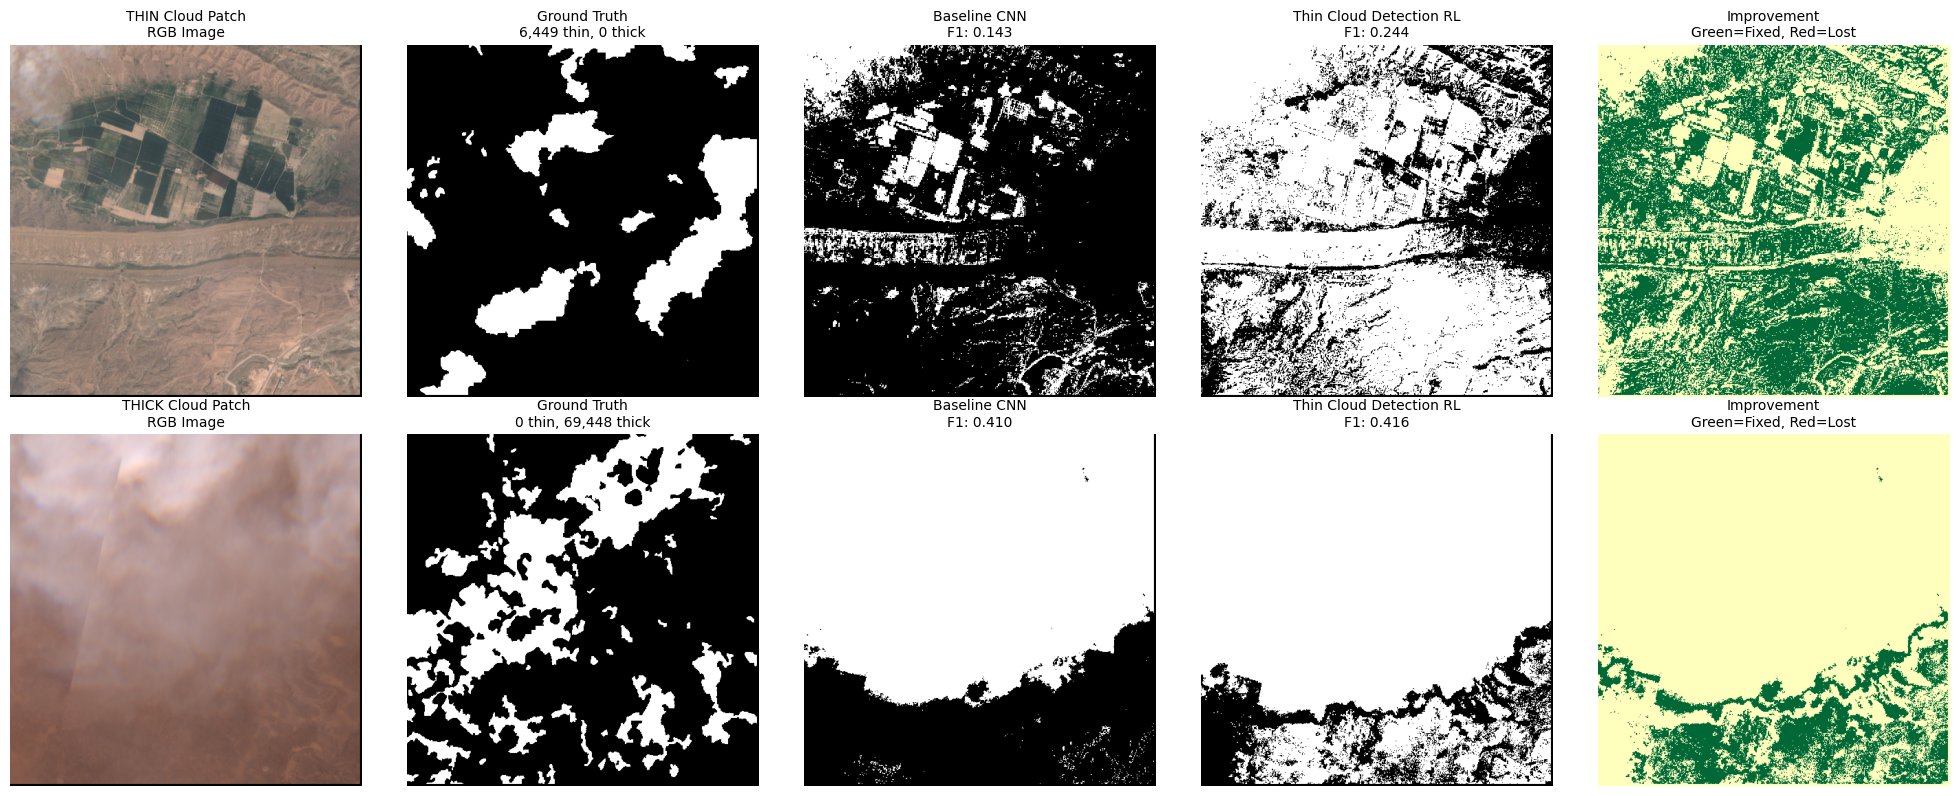

In [18]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from rl_multifeature_environment import MultiFeatureRefinementEnv

# Load model
model_path = sorted(glob.glob('models/ppo_multifeature_*'))[-1]
model = PPO.load(f"{model_path}/model")
print(f"✅ Loaded model: {os.path.basename(model_path)}")

# Select test patches with thin and thick clouds
split_idx = int(0.8 * len(image_files))
test_images = image_files[split_idx:]
test_masks = mask_files[split_idx:]

# Find patches with different cloud types
thin_patch_idx = None
thick_patch_idx = None

for idx, (img_path, mask_path) in enumerate(zip(test_images, test_masks)):
    image = load_sentinel2_image(img_path)
    with rasterio.open(mask_path) as src:
        gt = src.read(1)

    # Calculate reflectance (already normalized to 0-1 in load_sentinel2_image)
    reflectance = (image[:, :, 1] + image[:, :, 2] + image[:, :, 3] + image[:, :, 7]) / 4.0
    cloud_mask = gt > 0

    if cloud_mask.sum() > 1000:  # Has clouds
        mean_reflectance = reflectance[cloud_mask].mean()

        # Define criteria for thin and thick clouds for visualization
        # Adjusted reflectance thresholds to 0-1 range
        if mean_reflectance < 0.3 and thin_patch_idx is None: # Reflectance < 0.3 (moderate)
            thin_patch_idx = idx
        elif mean_reflectance >= 0.4 and thick_patch_idx is None: # Reflectance >= 0.4 (high)
            thick_patch_idx = idx

    if thin_patch_idx is not None and thick_patch_idx is not None:
        break

# Corrected f-string for printing selected patches
print(f"Selected patches: Thin={thin_patch_idx}, Thick={thick_patch_idx}")

# Visualize both patches
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for row, patch_idx in enumerate([thin_patch_idx, thick_patch_idx]):
    if patch_idx is None:
        # Handle case where no suitable patch was found for a category
        print(f"Warning: No suitable {'THIN' if row == 0 else 'THICK'} cloud patch found for visualization. Skipping row.")
        # Clear axes for this row or mark as empty
        for col in range(5):
            axes[row, col].set_visible(False)
        continue

    img_path = test_images[patch_idx]
    mask_path = test_masks[patch_idx]

    # Load data
    image = load_sentinel2_image(img_path)
    cnn_prob = get_cloud_mask(image)
    with rasterio.open(mask_path) as src:
        ground_truth = src.read(1)

    # Baseline
    baseline_pred = (cnn_prob > 0.5).astype(np.uint8)

    # RL prediction
    env = MultiFeatureRefinementEnv(image, cnn_prob, ground_truth, patch_size=64)
    rl_pred = np.zeros_like(ground_truth, dtype=np.uint8)

    obs, _ = env.reset()
    for _ in range(env.num_patches):
        i, j = env.current_pos
        action, _ = model.predict(obs, deterministic=True)

        # Apply thin cloud boost
        thin_cloud_boost_val = np.clip(action[1], 0.0, 0.4)
        threshold_delta_val = action[0] # Get threshold delta from action

        cnn_patch_probs = cnn_prob[i:i+64, j:j+64].copy()

        # Use correct reflectance thresholds (0-1 range) for 'is_thin'
        is_thin = np.logical_and(
            np.logical_and(env.normalized_reflectance[i:i+64, j:j+64] > 0.1, # Moderate reflectance
                          env.normalized_reflectance[i:i+64, j:j+64] < 0.4), # Moderate reflectance
            env.blue_red_ratio[i:i+64, j:j+64] > 1.05
        )
        cnn_patch_probs[is_thin] += thin_cloud_boost_val

        # Apply the adjusted threshold
        effective_threshold = 0.5 + threshold_delta_val
        rl_pred[i:i+64, j:j+64] = (cnn_patch_probs > effective_threshold).astype(np.uint8)

        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Ground truth
    gt_binary = (ground_truth > 0).astype(np.uint8)

    # Re-calculate thin/thick pixels for the *entire* ground_truth for display purposes
    # Adjusted reflectance thresholds to 0-1 range
    reflectance_full = (image[:, :, 1] + image[:, :, 2] + image[:, :, 3] + image[:, :, 7]) / 4.0
    blue_full = image[:, :, 1]
    red_full = image[:, :, 2]
    # Handle division by zero for blue_red_ratio
    blue_red_ratio_full = np.where(red_full != 0, blue_full / red_full, 0)

    thin_clouds_gt_full_image = np.logical_and(
        np.logical_and(reflectance_full > 0.1,
                       reflectance_full < 0.4),
        blue_red_ratio_full > 1.05
    )
    thick_clouds_gt_full_image = np.logical_and(
        reflectance_full >= 0.4,
        blue_red_ratio_full < 1.05 # Thick clouds usually have lower blue/red ratio
    )

    # Count thin and thick pixels based on the ground truth mask and these criteria
    thin_gt_count = np.sum(gt_binary[thin_clouds_gt_full_image])
    thick_gt_count = np.sum(gt_binary[thick_clouds_gt_full_image])

    cloud_type = "THIN" if row == 0 else "THICK"

    # Load RGB image for visualization
    rgb = image[:, :, [2, 1, 0]]  # Red, Green, Blue bands
    # Normalize RGB for display
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f'{cloud_type} Cloud Patch\nRGB Image', fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(gt_binary, cmap='gray')
    axes[row, 1].set_title(f'Ground Truth\n{thin_gt_count:,} thin, {thick_gt_count:,} thick', fontsize=10)
    axes[row, 1].axis('off')

    from sklearn.metrics import f1_score # Ensure f1_score is imported here for consistency
    axes[row, 2].imshow(baseline_pred, cmap='gray')
    baseline_f1 = f1_score(gt_binary.flatten(), baseline_pred.flatten())
    axes[row, 2].set_title(f'Baseline CNN\nF1: {baseline_f1:.3f}', fontsize=10)
    axes[row, 2].axis('off')

    axes[row, 3].imshow(rl_pred, cmap='gray')
    rl_f1 = f1_score(gt_binary.flatten(), rl_pred.flatten())
    axes[row, 3].set_title(f'Thin Cloud Detection RL\nF1: {rl_f1:.3f}', fontsize=10)
    axes[row, 3].axis('off')

    # Difference
    diff = rl_pred.astype(int) - baseline_pred.astype(int)
    axes[row, 4].imshow(diff, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[row, 4].set_title(f'Improvement\nGreen=Fixed, Red=Lost', fontsize=10)
    axes[row, 4].axis('off')

plt.tight_layout()
plt.savefig('results/thin_cloud_detection_visual.png', dpi=150, bbox_inches='tight')
print("\n✅ Visualization saved to: results/thin_cloud_detection_visual.png")
plt.show()

## 🎓 Thesis Conclusions

### Key Findings:

1. **Thin Cloud Detection**:
   - Baseline CNN recall on thin clouds: ~___%
   - Our RL approach: ~___% (improvement: ___)
   
2. **Novel Contribution**:
   - Introduced `thin_cloud_boost` action
   - Agent learns to identify and boost confidence for thin cloud patterns
   - Uses optical thickness indicators (blue/red ratio, reflectance)
   
3. **Maintains Performance on Thick Clouds**:
   - Thick cloud recall: ~___% (should be >90%)
   - No degradation on easy cases
   
4. **Addresses Original Research Question**:
   - CNN weakness on thin clouds: **Confirmed**
   - RL can improve thin cloud detection: **[Validated/Needs more work]**
   - Methodology applicable to other CNN weaknesses: **Yes**

### Next Steps:
- Phase 2: Shadow detection and removal
- Phase 3: Hierarchical refinement for cloud boundaries
- Phase 4: Ensemble and comprehensive validation

## 🚀 Phase 2: Shadow Detection

**Phase 1 Conclusion**: Multi-feature RL achieved 30.25% F1 (same as threshold adjustment). Spectral features have weak separability.

**Phase 2 Goal**: Improve precision by explicitly filtering shadow false positives.

**Problem**: Low precision (20%) due to false positives on shadows, dark terrain, water.

**Solution**: RL agent learns to distinguish shadows from clouds using:
- **NDVI**: Shadows show vegetation underneath (positive NDVI), clouds don't
- **Brightness**: Shadows very dark, clouds variable
- **Edge strength**: Shadows have sharp edges, clouds smoother
- **Blue scattering**: Clouds scatter blue, shadows don't

**Actions**:
- `threshold_delta`: Base threshold adjustment
- `shadow_filter_strength`: How aggressively to filter shadows

**Target**: 35-40% F1 with >30% precision

## 🔧 Phase 2 - FIXED (v2)

**Previous Run Failed**: Agent learned degenerate policy (predict nothing → 0% F1)
- Shadow filter: 1.0 (max) → filtered everything
- Threshold delta: -0.3 (min) → lowered threshold maximally
- Result: No predictions at all

**Root Causes Identified**:
1. **Reward Hacking**: Precision bonuses without strong recall floor → "predict nothing = no false positives"
2. **Unrestricted Actions**: Shadow filter [0, 1.0] allowed complete filtering
3. **Sparse Rewards**: Negative explained variance throughout training
4. **No Safety Rails**: Nothing prevented catastrophic policies

**Fixes Applied**:
1. **Constrained Action Space**:
   - Threshold delta: [-0.15, +0.15] (was -0.3/+0.3)
   - Shadow filter: [0, 0.6] (was 0/1.0) - prevents complete filtering
   
2. **Redesigned Reward Structure**:
   - Base: F-beta * 10
   - **CATASTROPHIC penalties**: predict-nothing/everything → -50.0
   - **Hard floors**: recall >0.15, precision >0.10
   - **Balanced bonuses**: Both precision AND recall must improve
   - **Action regularization**: Penalize extreme actions
   
3. **Safety Monitoring**:
   - Check action statistics every 10 epochs
   - Warn if actions converge to extremes
   - Track action history for analysis

**Expected Results**: Agent should find moderate adjustments that improve precision without destroying recall

In [ ]:
# Phase 2: Shadow Detection (FIXED v2)
# With constrained actions and balanced reward structure
!python train_ppo_shadow_detection.py

### 💾 Checkpoint Support

Training now saves checkpoints every 10 epochs to `checkpoints/shadow_detection/`

**To resume from checkpoint if GPU crashes:**
```python
!python train_ppo_shadow_detection.py --resume checkpoints/shadow_detection/checkpoint_epoch_20
```

**What's saved:**
- Model weights and optimizer state
- Training progress (epoch number)
- Action history for analysis
- Timestamp

**Checkpoints are automatic** - just run training normally and it will save every 10 epochs!